In [26]:
# 套件引入
import requests
import pandas as pd
from bs4 import BeautifulSoup
import json
import numpy as np
import csv
import jieba
import matplotlib.pyplot as plt
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties
import unicodedata

In [27]:
#主要會透過API去獲取網站內容
#因為一次只能抓取100則，所以透過更改StartNewsID來獲取更多內容
def getRequestsData(StartNewsID):
    data_list=[]
    url='https://www.cupoy.com/MixNewsMongoAction.do?'
    par='op=getTopMixNews&nationid=TW&startNewsID={StartNewsID}&len=100'.format(StartNewsID=StartNewsID)
    res = requests.get(url,par)
    
    News_data = json.loads(res.text)#以json檔進行篩選
    
    for i in News_data["items"]:
        title = i['title']

        if 'description' in i.keys() :
            description = i['description']

        if 'linkurl' in i.keys() :
            linkurl = i['linkurl']
            
        data_list.append([title, description, linkurl])
    
    return data_list

In [28]:
#將整理出來的資料存在list變數中
TotalData_list=[]
for i in range(0,500,100):
    TotalData_list=TotalData_list+getRequestsData(i)
    print("寫入陣列完成...")

寫入陣列完成...
寫入陣列完成...
寫入陣列完成...
寫入陣列完成...
寫入陣列完成...


In [29]:
#看一下結果是否正確
TotalData_list[:5]

[['Facebook 推出視訊通話服務，最多可供 50 人同時在線 | TechNews 科技新報',
  '為針對肺炎期間的使用需求，Facebook 推出視訊會議服務 Messenger Rooms，用戶可在 Facebook、Messenger、WhatsApp 等平臺上發起，邀請其他用戶參與視訊通話，沒有 Facebook 平臺賬戶的用戶也可以參與，每次最多可供 50 人同時使用，沒有時間限制。\r\n...',
  'https://technews.tw/2020/04/26/facebook-rolling-out-free-video-calling-for-up-to-50-people/?utm_source=fb_tn&utm_medium=facebook'],
 ['華為貢獻營收增至 14%，法人：臺積電有隱憂 | TechNews 科技新報',
  '華為去年貢獻臺積電新臺幣 1,528.76 億元業績，年增逾 8 成，佔營收比重 14%，為臺積電第 2 大客戶。法人認為，美國若對華為加強管制出口，將是臺積電未來的隱憂。\r\n臺積電去年營收約 1.07 兆元，連續 10 年創紀錄，臺積電近日公佈的年報資料顯示，臺積電最大客戶去年貢獻 2,472.1...',
  'https://technews.tw/2020/04/25/huawei-ban-tsmc/?utm_source=fb_tn&utm_medium=facebook'],
 ['「地平線」的英文怎麼說？ | 經理人',
  '你曾在海邊看過日出嗎？看著太陽從地平線緩緩升起，一定很漂亮。horizon 的形容詞變化是 horizontal，意思是水平的、平行的。### 例句：- Guests can take a walk ',
  'http://sc.piee.pw/NM3QF'],
 ['Google 在支援文件中意外漏出通話錄音功能的細節',
  '今年稍早的時候，曾有傳聞說 Google 將在 Android 的基本電話 app 當中，加入通話錄音的功能，且據 XDA Developers 報導，這個功能似乎已經來到部份印度的 Nokia 手機上進行測試。現在，Google 又意外提早放出了一份支援文章（已經被撤下），說明該功能的內容、使用流程與限制。  由 G

In [30]:
# 將取得的文章資訊轉為DataFrame
df = pd.DataFrame(TotalData_list, columns=['title', 'description', 'linkurl'])
df.head()

,title,description,linkurl
0,Facebook 推出視訊通話服務，最多可供 50 人同時在線 | TechNews 科技新報,為針對肺炎期間的使用需求，Facebook 推出視訊會議服務 Messenger Rooms...,https://technews.tw/2020/04/26/facebook-rollin...
1,華為貢獻營收增至 14%，法人：臺積電有隱憂 | TechNews 科技新報,"華為去年貢獻臺積電新臺幣 1,528.76 億元業績，年增逾 8 成，佔營收比重 14%，為...",https://technews.tw/2020/04/25/huawei-ban-tsmc...
2,「地平線」的英文怎麼說？ | 經理人,你曾在海邊看過日出嗎？看著太陽從地平線緩緩升起，一定很漂亮。horizon 的形容詞變化是 ...,http://sc.piee.pw/NM3QF
3,Google 在支援文件中意外漏出通話錄音功能的細節,今年稍早的時候，曾有傳聞說 Google 將在 Android 的基本電話 app 當中，加...,https://chinese.engadget.com/chinese-2020-04-2...
4,"Meet Peter Tsai, the Taiwanese Inventor Behind...",The COVID-19 pandemic turned respirators into ...,https://english.cw.com.tw/article/article.acti...


In [31]:
#使用jieba套件
jieba.set_dictionary('jiebaDict.txt')
stopWords=[]
NewsTitleCut=[]
stopWord=['  ',' ',' ','』','『','／','●','⋯','...','─','"','—','.','\n','*','--','‧']#去除掉一些額外符號
with open('stopWord.txt', 'r', encoding='UTF-8') as file:
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)

def NewsCut(index):
    dfTitle=unicodedata.normalize('NFKC',df['title'][index])#去掉\u3000等符號
    words=jieba.cut(dfTitle,cut_all=False)
    for i in words:
        if i not in stopWords and i not in stopWord:
            NewsTitleCut.append(i)

In [32]:
#執行NewsCut來進行分詞
Newsnumber=0
for i in range(500):
    NewsCut(Newsnumber)
    Newsnumber+=1
np.set_printoptions(threshold=np.inf)
NewsTitleCut[:5]

Building prefix dict from C:\Users\tut\PythonTest\jiebaDict.txt ...
Loading model from cache C:\Users\tut\AppData\Local\Temp\jieba.ufeb109c70b4bed855e5ab043cd091ab6.cache
Loading model cost 0.478 seconds.
Prefix dict has been built successfully.


['Facebook', '推出', '視訊', '通話', '服務']

In [33]:
#統計出關鍵字出現次數
columns=['關鍵字']
NewsKeyWordTable=pd.DataFrame(NewsTitleCut,columns=columns)
NewsKeyWordTable=pd.DataFrame(NewsKeyWordTable.groupby('關鍵字').size(),columns=['amount'])
NewsKeyWordTable=NewsKeyWordTable.loc[NewsKeyWordTable.amount>=10].sort_values(by='amount',ascending=False)
NewsKeyWordTable.head()#查看是否有混入奇怪的關鍵字

,amount
關鍵字,
旅遊,84
新聞,59
ETtoday,51
媽媽,37
妞,30


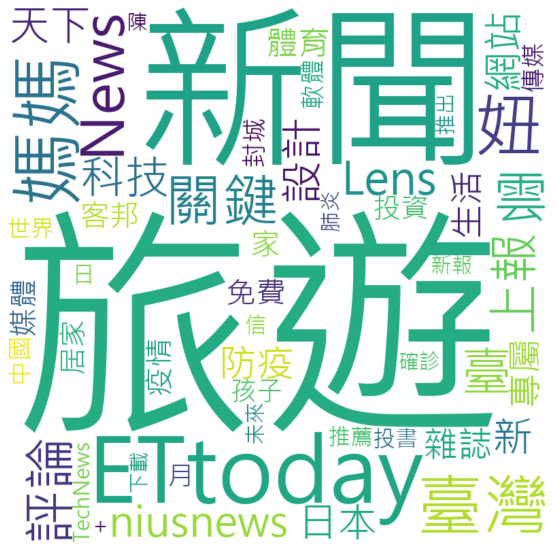

In [34]:
#顯示熱門新聞中較常出現關鍵字的文字雲
NewsData_dict=NewsKeyWordTable.to_dict(orient="dict")
NewsData_dict_amount=NewsData_dict['amount']
wc=WordCloud(background_color="white", font_path=r'msjh.ttc', collocations=False, width=800, height=800)
wc.generate_from_frequencies(NewsData_dict_amount)
plt.figure(figsize=(10,10))
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

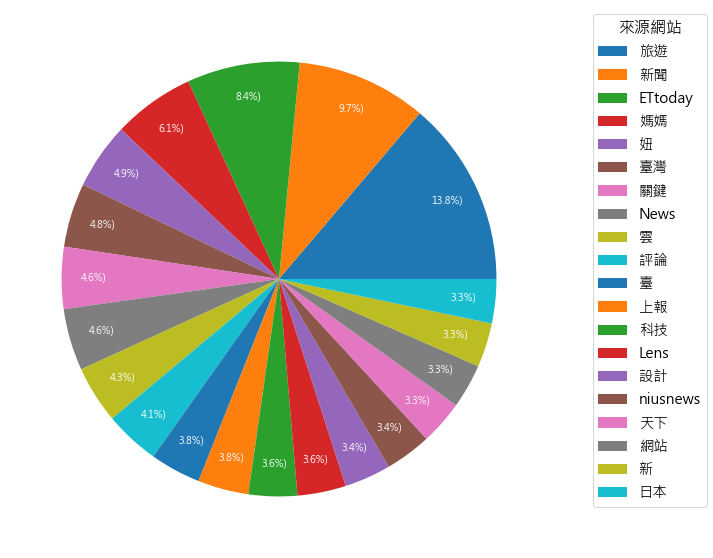

In [35]:
#重新抓取熱文新聞中出現的關鍵字，並指定出現次數超過20次(避免過於雜亂)
NewsKeyWordTable=NewsKeyWordTable.loc[NewsKeyWordTable.amount>=20].sort_values(by='amount',ascending=False)
NewsData_dict=NewsKeyWordTable.to_dict(orient="dict")
NewsData_dict_amount=NewsData_dict['amount']
NewsData = list(NewsData_dict_amount.values())
NewsDatakeys = NewsData_dict_amount.keys()

#指定使用字體，使 matplotlib 能夠顯示中文字
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,10))

#標簽位於其中
def func(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return "{:.1f}%)".format(pct)

plt.pie(NewsData, autopct=lambda pct: func(pct, NewsData), textprops=dict(color="w"), pctdistance=0.85)
graph = plt.legend(NewsDatakeys, title="網站來源", bbox_to_anchor=(1, 0, 0.3, 1), fontsize="x-large")
graph.set_title('來源網站',prop={'size':16})

plt.show()